In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box

In [2]:
!pip install geopandas shapely pyproj

In [3]:
# ============================================================
# PIPELINE D — PATH CONFIGURATION
# ============================================================

MOBILITY_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

GEOMETRY_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S1/"
    "census_tracts_brazil_ibge_2022.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)"
)

In [4]:
import os
import math
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box

print("▶️ Starting Pipeline D — Block D1 (TILED): Grid Construction")
print("-----------------------------------------------------------")

# ------------------------------------------------------------
# Paths (OFICIAIS)
# ------------------------------------------------------------
MOBILITY_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

GEOMETRY_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S1/"
    "census_tracts_brazil_ibge_2022.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)"
)

OUT_D1_DIR = os.path.join(OUTPUT_DIR, "D1_tiles_gpkg")
os.makedirs(OUT_D1_DIR, exist_ok=True)

# ------------------------------------------------------------
# Parameters
# ------------------------------------------------------------
GRID_SIZE = 100      # meters
TILE_SIZE = 50_000   # meters (50 km)  ✅ ajuste se necessário: 25_000 ou 100_000

# ------------------------------------------------------------
# 1) Active sectors (mii > 0)
# ------------------------------------------------------------
mobility = pd.read_csv(MOBILITY_INPUT, compression="gzip", usecols=["ct_id", "mii"])
mobility["ct_id"] = mobility["ct_id"].astype(str)

active_ids = mobility.loc[mobility["mii"] > 0, "ct_id"].unique()
print(f"✔ Active census tracts (mii > 0): {len(active_ids):,}")

# ------------------------------------------------------------
# 2) Load geometries and filter
# ------------------------------------------------------------
sectors = gpd.read_file(GEOMETRY_INPUT)[["ct_id", "geometry"]].copy()
sectors["ct_id"] = sectors["ct_id"].astype(str)
sectors = sectors[sectors["ct_id"].isin(active_ids)].copy()

print(f"✔ Geometries retained after filter: {len(sectors):,}")

# Metric CRS for tiling/grid
sectors = sectors.to_crs(epsg=3857)

# ------------------------------------------------------------
# 3) Prepare tiling extents
# ------------------------------------------------------------
minx, miny, maxx, maxy = sectors.total_bounds

nx = math.ceil((maxx - minx) / TILE_SIZE)
ny = math.ceil((maxy - miny) / TILE_SIZE)

print(f"✔ Tiling grid: {nx} × {ny} tiles (TILE_SIZE={TILE_SIZE}m)")

# Spatial index speeds up intersection candidate search
# (GeoPandas builds sindex lazily)
_ = sectors.sindex

tile_count = 0
written = 0

# ------------------------------------------------------------
# 4) Process tiles
# ------------------------------------------------------------
for ix in range(nx):
    for iy in range(ny):
        tile_count += 1

        tx0 = minx + ix * TILE_SIZE
        ty0 = miny + iy * TILE_SIZE
        tx1 = min(tx0 + TILE_SIZE, maxx)
        ty1 = min(ty0 + TILE_SIZE, maxy)

        tile_geom = box(tx0, ty0, tx1, ty1)

        # Candidate sectors by bbox (fast)
        cand_idx = list(sectors.sindex.intersection(tile_geom.bounds))
        if not cand_idx:
            continue

        cand = sectors.iloc[cand_idx]
        # Keep only sectors that actually intersect the tile
        cand = cand[cand.intersects(tile_geom)]
        if cand.empty:
            continue

        # Create grid only for this tile (100m)
        x_coords = np.arange(tx0, tx1, GRID_SIZE)
        y_coords = np.arange(ty0, ty1, GRID_SIZE)

        grid_cells = [box(x, y, x + GRID_SIZE, y + GRID_SIZE) for x in x_coords for y in y_coords]
        grid = gpd.GeoDataFrame(
            {"grid_id": np.arange(len(grid_cells), dtype=np.int64)},
            geometry=grid_cells,
            crs=sectors.crs
        )

        # Clip grid to tile sectors bbox intersection using overlay
        # overlay(grid, cand) only within tile, much smaller
        grid_frag = gpd.overlay(grid, cand, how="intersection")
        if grid_frag.empty:
            continue

        # Add tile id to support merging/auditing
        grid_frag["tile_ix"] = ix
        grid_frag["tile_iy"] = iy

        out_path = os.path.join(OUT_D1_DIR, f"D1_tile_ix{ix:03d}_iy{iy:03d}.gpkg")
        grid_frag.to_file(out_path, driver="GPKG")

        written += 1

        if written % 10 == 0:
            print(f"  ... wrote {written} tile files so far (processed tiles: {tile_count})")

print("✅ Block D1 (TILED) completed.")
print(f"📁 Tiles written: {written:,}")
print(f"📂 Output folder: {OUT_D1_DIR}")

▶️ Starting Pipeline D — Block D1 (TILED): Grid Construction
-----------------------------------------------------------
✔ Active census tracts (mii > 0): 301,013
✔ Geometries retained after filter: 277,781
✔ Tiling grid: 93 × 90 tiles (TILE_SIZE=50000m)
  ... wrote 10 tile files so far (processed tiles: 243)
  ... wrote 20 tile files so far (processed tiles: 602)
  ... wrote 30 tile files so far (processed tiles: 870)
  ... wrote 40 tile files so far (processed tiles: 1137)
  ... wrote 50 tile files so far (processed tiles: 1229)
  ... wrote 60 tile files so far (processed tiles: 1324)
  ... wrote 70 tile files so far (processed tiles: 1605)
  ... wrote 80 tile files so far (processed tiles: 1783)
  ... wrote 90 tile files so far (processed tiles: 1942)
  ... wrote 100 tile files so far (processed tiles: 2123)
  ... wrote 110 tile files so far (processed tiles: 2211)
  ... wrote 120 tile files so far (processed tiles: 2305)
  ... wrote 130 tile files so far (processed tiles: 2396)
  .

In [5]:
import os
import geopandas as gpd
import pandas as pd

print("▶️ Starting Pipeline D — Block D1b: Merge Tiles")
print("------------------------------------------------")

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
TILES_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D1_tiles_gpkg"
)

OUTPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D1_grid_100m_national.gpkg"
)

# ------------------------------------------------------------
# 1) List tile files
# ------------------------------------------------------------
tile_files = [
    os.path.join(TILES_DIR, f)
    for f in os.listdir(TILES_DIR)
    if f.endswith(".gpkg")
]

print(f"✔ Tile files found: {len(tile_files):,}")

# ------------------------------------------------------------
# 2) Read and concatenate
# ------------------------------------------------------------
gdfs = []
for i, fp in enumerate(tile_files, 1):
    gdf = gpd.read_file(fp)
    gdfs.append(gdf)

    if i % 200 == 0:
        print(f"  ... loaded {i} tiles")

grid = gpd.GeoDataFrame(
    pd.concat(gdfs, ignore_index=True),
    crs=gdfs[0].crs
)

print(f"✔ Total grid cells after merge: {len(grid):,}")

# ------------------------------------------------------------
# 3) Create unique grid id
# ------------------------------------------------------------
grid["grid_uid"] = (
    grid["ct_id"].astype(str)
    + "_"
    + grid.index.astype(str)
)

# ------------------------------------------------------------
# 4) Save merged grid
# ------------------------------------------------------------
grid.to_file(OUTPUT_PATH, driver="GPKG")

print("✅ Block D1b completed successfully.")
print(f"📄 Output saved to:\n{OUTPUT_PATH}")

▶️ Starting Pipeline D — Block D1b: Merge Tiles
------------------------------------------------
✔ Tile files found: 2,408
  ... loaded 200 tiles
  ... loaded 400 tiles
  ... loaded 600 tiles
  ... loaded 800 tiles
  ... loaded 1000 tiles
  ... loaded 1200 tiles
  ... loaded 1400 tiles
  ... loaded 1600 tiles
  ... loaded 1800 tiles
  ... loaded 2000 tiles
  ... loaded 2200 tiles
  ... loaded 2400 tiles
✔ Total grid cells after merge: 98,155,471
✅ Block D1b completed successfully.
📄 Output saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D1_grid_100m_national.gpkg


In [1]:
# ============================================================
# PIPELINE D — BLOCK D2 (TILED)
# Nighttime Lights Prior (Tile-based)
# ============================================================

import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import os
from tqdm import tqdm

print("▶️ Starting Pipeline D — Block D2 (TILED): Nighttime Lights Prior")
print("---------------------------------------------------------------")

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
TILES_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D1_tiles_gpkg"
)

RASTER_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Nightlights/VIIRS_annual_2024.tif"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D2_tiles_nightlights_gpkg"
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

tile_files = sorted([
    f for f in os.listdir(TILES_DIR) if f.endswith(".gpkg")
])

print(f"✔ Tiles found: {len(tile_files)}")

# ------------------------------------------------------------
# Open raster once
# ------------------------------------------------------------
with rasterio.open(RASTER_PATH) as src:

    raster_crs = src.crs
    nodata = src.nodata

    for i, tile_file in enumerate(tqdm(tile_files)):
        tile_path = os.path.join(TILES_DIR, tile_file)
        out_path = os.path.join(OUTPUT_DIR, tile_file.replace("D1_", "D2_"))

        # Load tile
        gdf = gpd.read_file(tile_path)

        if gdf.crs != raster_crs:
            gdf = gdf.to_crs(raster_crs)

        night_vals = []

        # Mask raster by tile geometry (one window!)
        try:
            geom = [gdf.unary_union]
            out_img, _ = mask(src, geom, crop=True)
            raster_tile = out_img[0]
            raster_tile = raster_tile[raster_tile != nodata]
        except Exception:
            raster_tile = np.array([])

        if raster_tile.size == 0:
            gdf["nightlights_raw"] = 0.0
        else:
            mean_val = float(np.mean(raster_tile))
            gdf["nightlights_raw"] = mean_val

        # Save
        gdf_out = gdf[["ct_id", "nightlights_raw", "geometry"]]
        gdf_out.to_file(out_path, driver="GPKG")

        if (i + 1) % 100 == 0:
            print(f"  ... processed {i+1} tiles")

print("✅ Block D2 (TILED) completed successfully.")
print(f"📂 Output folder:\n{OUTPUT_DIR}")

▶️ Starting Pipeline D — Block D2 (TILED): Nighttime Lights Prior
---------------------------------------------------------------
✔ Tiles found: 2408


  0%|          | 0/2408 [00:00<?, ?it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  0%|          | 1/2408 [00:00<07:53,  5.08it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  0%|          | 2/2408 [00:02<59:42,  1.49s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  0%|          | 3/2408 [00:02<34:46,  1.15it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  g

  ... processed 100 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  4%|▍         | 101/2408 [00:51<21:52,  1.76it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  4%|▍         | 102/2408 [00:51<19:05,  2.01it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  4%|▍         | 103/2408 [00:51<16:28,  2.33it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folde

  ... processed 200 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  8%|▊         | 201/2408 [01:58<37:55,  1.03s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  8%|▊         | 202/2408 [01:59<29:12,  1.26it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
  8%|▊         | 203/2408 [01:59<29:24,  1.25it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folde

  ... processed 300 tiles


 12%|█▎        | 301/2408 [03:27<15:39,  2.24it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 13%|█▎        | 302/2408 [03:28<13:19,  2.64it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 13%|█▎        | 303/2408 [03:28<11:56,  2.94it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 13%|█▎        | 304/2408 [03:28<10:12,  3.44it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' met

  ... processed 400 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 17%|█▋        | 401/2408 [05:03<30:10,  1.11it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 17%|█▋        | 402/2408 [05:04<33:41,  1.01s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 17%|█▋        | 403/2408 [05:05<34:20,  1.03s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folde

  ... processed 500 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 21%|██        | 501/2408 [07:05<1:41:47,  3.20s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 21%|██        | 502/2408 [07:06<1:24:28,  2.66s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 21%|██        | 503/2408 [07:09<1:23:06,  2.62s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 21%

  ... processed 600 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 25%|██▍       | 601/2408 [09:11<43:54,  1.46s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 25%|██▌       | 602/2408 [09:12<42:08,  1.40s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 25%|██▌       | 604/2408 [09:14<36:17,  1.21s/it]/var/folde

  ... processed 700 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 29%|██▉       | 701/2408 [11:23<39:40,  1.39s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 29%|██▉       | 702/2408 [11:25<43:06,  1.52s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 29%|██▉       | 703/2408 [11:26<40:44,  1.43s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 29%|██▉  

  ... processed 800 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 33%|███▎      | 802/2408 [14:03<29:11,  1.09s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 33%|███▎      | 803/2408 [14:06<41:31,  1.55s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 33%|███▎      | 804/2408 [14:09<51:41,  1.93s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 33%|███▎ 

  ... processed 900 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 37%|███▋      | 901/2408 [16:39<57:42,  2.30s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 37%|███▋      | 902/2408 [16:39<42:09,  1.68s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 38%|███▊      | 903/2408 [16:41<44:38,  1.78s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 38%|███▊ 

  ... processed 1000 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 42%|████▏     | 1001/2408 [19:18<12:25,  1.89it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 42%|████▏     | 1002/2408 [19:22<30:03,  1.28s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 42%|████▏     | 1003/2408 [19:22<23:22,  1.00it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 42%|██

  ... processed 1100 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 46%|████▌     | 1101/2408 [22:24<48:21,  2.22s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 46%|████▌     | 1102/2408 [22:28<59:34,  2.74s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 46%|████▌     | 1103/2408 [22:32<1:07:24,  3.10s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 46%|

  ... processed 1200 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 50%|████▉     | 1201/2408 [25:20<17:23,  1.16it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 50%|████▉     | 1202/2408 [25:24<30:57,  1.54s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 50%|████▉     | 1203/2408 [25:27<38:38,  1.92s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 50%|██

  ... processed 1300 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 54%|█████▍    | 1302/2408 [28:32<13:28,  1.37it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 54%|█████▍    | 1303/2408 [28:33<17:40,  1.04it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 54%|█████▍    | 1304/2408 [28:35<22:22,  1.22s/it]/var/fo

  ... processed 1400 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 58%|█████▊    | 1401/2408 [31:44<29:20,  1.75s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 58%|█████▊    | 1402/2408 [31:46<27:49,  1.66s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 58%|█████▊    | 1403/2408 [31:46<21:17,  1.27s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 58%|██

  ... processed 1500 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 62%|██████▏   | 1501/2408 [34:41<26:51,  1.78s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 62%|██████▏   | 1502/2408 [34:43<30:21,  2.01s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 62%|██████▏   | 1503/2408 [34:46<31:21,  2.08s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 62%|██

  ... processed 1600 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 66%|██████▋   | 1601/2408 [36:56<07:18,  1.84it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 67%|██████▋   | 1603/2408 [36:57<05:27,  2.46it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel

  ... processed 1700 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 71%|███████   | 1701/2408 [38:52<09:08,  1.29it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 71%|███████   | 1702/2408 [38:53<11:26,  1.03it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 71%|███████   | 1703/2408 [38:54<11:17,  1.04it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 71%|██

  ... processed 1800 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 75%|███████▍  | 1801/2408 [40:57<05:01,  2.01it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 75%|███████▍  | 1802/2408 [40:58<04:02,  2.49it/s]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 75%|███████▍  | 1803/2408 [41:09<36:53,  3.66s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 75%|██

  ... processed 1900 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 79%|███████▉  | 1901/2408 [43:18<19:37,  2.32s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 79%|███████▉  | 1902/2408 [43:20<17:34,  2.08s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 79%|███████▉  | 1903/2408 [43:25<25:40,  3.05s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 79%|██

  ... processed 2000 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 83%|████████▎ | 2001/2408 [45:13<10:29,  1.55s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 83%|████████▎ | 2002/2408 [45:16<12:21,  1.83s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 83%|████████▎ | 2003/2408 [45:17<11:43,  1.74s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 83%|██

  ... processed 2100 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 87%|████████▋ | 2101/2408 [47:25<06:01,  1.18s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 87%|████████▋ | 2102/2408 [47:27<07:29,  1.47s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 87%|████████▋ | 2103/2408 [47:28<06:14,  1.23s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 87%|██

  ... processed 2200 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 91%|█████████▏| 2201/2408 [49:44<03:33,  1.03s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 91%|█████████▏| 2202/2408 [49:46<04:43,  1.38s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 91%|█████████▏| 2203/2408 [49:46<03:52,  1.14s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 92%|██

  ... processed 2300 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 96%|█████████▌| 2301/2408 [51:53<01:47,  1.01s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 96%|█████████▌| 2302/2408 [51:56<02:44,  1.56s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 96%|█████████▌| 2303/2408 [51:57<02:35,  1.48s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
 96%|██

  ... processed 2400 tiles


/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
100%|█████████▉| 2401/2408 [55:25<00:17,  2.50s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
100%|█████████▉| 2402/2408 [55:29<00:18,  3.03s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
100%|█████████▉| 2403/2408 [55:32<00:15,  3.11s/it]/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_6416/2507375002.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = [gdf.unary_union]
100%|██

✅ Block D2 (TILED) completed successfully.
📂 Output folder:
/Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D2_tiles_nightlights_gpkg


In [2]:
# ============================================================
# PIPELINE D — BLOCK D2b
# Merge Tiles + Normalize Nightlights Prior
# ============================================================

import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm

print("▶️ Starting Pipeline D — Block D2b: Merge + Normalize")
print("----------------------------------------------------")

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
TILES_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D2_tiles_nightlights_gpkg"
)

OUTPUT_FILE = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D2_grid_100m_with_nightlights_prior.gpkg"
)

tile_files = sorted([
    f for f in os.listdir(TILES_DIR) if f.endswith(".gpkg")
])

print(f"✔ Tile files found: {len(tile_files)}")

# ------------------------------------------------------------
# 1. Merge tiles incrementally (memory-safe)
# ------------------------------------------------------------
gdfs = []

for i, tile in enumerate(tqdm(tile_files)):
    path = os.path.join(TILES_DIR, tile)
    gdf = gpd.read_file(path)
    gdfs.append(gdf)

    if (i + 1) % 300 == 0:
        print(f"  ... loaded {i+1} tiles")

grid = pd.concat(gdfs, ignore_index=True)
grid = gpd.GeoDataFrame(grid, geometry="geometry", crs=gdfs[0].crs)

print(f"✔ Total grid cells after merge: {len(grid):,}")

# ------------------------------------------------------------
# 2. Normalize nightlights within census tract
# ------------------------------------------------------------
print("▶️ Normalizing nightlights within census tracts...")

grid["nightlights_weight"] = (
    grid.groupby("ct_id")["nightlights_raw"]
        .transform(lambda x: x / x.sum() if x.sum() > 0 else 0.0)
)

# ------------------------------------------------------------
# 3. Sanity checks
# ------------------------------------------------------------
check = (
    grid.groupby("ct_id")["nightlights_weight"]
        .sum()
        .reset_index(name="weight_sum")
)

print("✔ Weight sum diagnostics (should be 1.0):")
print(check["weight_sum"].describe())

# ------------------------------------------------------------
# 4. Save output
# ------------------------------------------------------------
grid_out = grid[[
    "ct_id",
    "nightlights_raw",
    "nightlights_weight",
    "geometry"
]]

grid_out.to_file(OUTPUT_FILE, driver="GPKG")

print("✅ Block D2b completed successfully.")
print(f"📄 Output saved to:\n{OUTPUT_FILE}")

▶️ Starting Pipeline D — Block D2b: Merge + Normalize
----------------------------------------------------
✔ Tile files found: 2408


 13%|█▎        | 304/2408 [00:17<01:17, 27.06it/s]

  ... loaded 300 tiles


 25%|██▌       | 602/2408 [00:44<03:18,  9.10it/s]

  ... loaded 600 tiles


 37%|███▋      | 900/2408 [01:18<03:10,  7.93it/s]

  ... loaded 900 tiles


 50%|████▉     | 1200/2408 [02:00<01:07, 17.80it/s]

  ... loaded 1200 tiles


 62%|██████▏   | 1500/2408 [02:45<01:55,  7.87it/s]

  ... loaded 1500 tiles


 75%|███████▍  | 1800/2408 [03:26<00:42, 14.39it/s]

  ... loaded 1800 tiles


 87%|████████▋ | 2100/2408 [03:55<00:33,  9.31it/s]

  ... loaded 2100 tiles


100%|█████████▉| 2398/2408 [04:44<00:02,  3.63it/s]

  ... loaded 2400 tiles


100%|██████████| 2408/2408 [04:45<00:00,  8.43it/s]


✔ Total grid cells after merge: 98,155,471
▶️ Normalizing nightlights within census tracts...
✔ Weight sum diagnostics (should be 1.0):
count    277261.000000
mean          0.999917
std           0.009108
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: weight_sum, dtype: float64


FeatureError: Could not add feature to layer at index 1127685: failed to execute insert : database or disk is full

In [1]:
# ============================================================
# PIPELINE D — BLOCK D4 (SAFE)
# Mass-Preserving Allocation of MII to 100m Grid
# - NO raster
# - NO tiles
# - Chunked reads from GPKG using pyogrio (no fiona)
# - Output as CSV.GZ parts (lightweight, safe)
# ============================================================

import os
import math
import gc
import numpy as np
import pandas as pd

# ---- Optional: faster I/O for GPKG without fiona
try:
    import pyogrio
except ImportError as e:
    raise ImportError(
        "pyogrio is required for chunked reading of GPKG without loading everything into memory.\n"
        "Install with: pip install pyogrio"
    ) from e


print("▶️ Starting Pipeline D — Block D4 (SAFE): MII Allocation (Uniform Intra-Tract)")
print("--------------------------------------------------------------------------")

# ------------------------------------------------------------
# Paths (your official paths)
# ------------------------------------------------------------
GRID_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D1_grid_100m_national.gpkg"
)

MII_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

# (Optional) tract-level nightlights for later analysis / QC (NOT used in allocation)
NIGHTLIGHTS_TRACT_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D4_mii_grid_parts_csv"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

QC_DIR = os.path.join(OUTPUT_DIR, "_QC")
os.makedirs(QC_DIR, exist_ok=True)

# ------------------------------------------------------------
# Parameters
# ------------------------------------------------------------
LAYER = None                 # None = default layer in GPKG
CHUNK_SIZE = 2_000_000       # adjust if needed (1M–3M typical)
WRITE_FLOAT32 = True         # reduce disk size

# ------------------------------------------------------------
# 1) Load MII by tract
# ------------------------------------------------------------
mii_df = pd.read_csv(MII_INPUT, compression="gzip", usecols=["ct_id", "mii"])
mii_df["ct_id"] = mii_df["ct_id"].astype(str)
mii_map = dict(zip(mii_df["ct_id"].values, mii_df["mii"].values))

print(f"✔ MII loaded for {len(mii_df):,} census tracts")

# ------------------------------------------------------------
# 2) Discover feature count in grid GPKG
# ------------------------------------------------------------
meta = pyogrio.read_info(GRID_INPUT, layer=LAYER)
n_features = meta["features"]
print(f"✔ Grid feature count: {n_features:,}")

n_chunks = math.ceil(n_features / CHUNK_SIZE)
print(f"▶️ Will process {n_chunks:,} chunks (CHUNK_SIZE={CHUNK_SIZE:,})")

# ------------------------------------------------------------
# 3) PASS A: Count grid cells per tract (ct_id -> n_cells)
# ------------------------------------------------------------
print("▶️ PASS A: Counting grid cells per ct_id...")

counts = {}  # ct_id -> n_cells

for k in range(n_chunks):
    skip = k * CHUNK_SIZE
    maxf = min(CHUNK_SIZE, n_features - skip)

    df = pyogrio.read_dataframe(
        GRID_INPUT,
        layer=LAYER,
        columns=["ct_id"],
        skip_features=skip,
        max_features=maxf
    )

    # Ensure type stability
    df["ct_id"] = df["ct_id"].astype(str)

    vc = df["ct_id"].value_counts(dropna=False)

    # Update dict counts
    for ct, c in vc.items():
        counts[ct] = counts.get(ct, 0) + int(c)

    if (k + 1) % 10 == 0 or (k + 1) == n_chunks:
        print(f"  ... PASS A processed chunk {k+1:,}/{n_chunks:,}")

    del df, vc
    gc.collect()

print(f"✔ PASS A done. Unique ct_id in grid: {len(counts):,}")

# Save counts (audit)
counts_path = os.path.join(QC_DIR, "D4_cells_per_ct_id.csv.gz")
pd.Series(counts, name="n_cells").rename_axis("ct_id").to_csv(counts_path, compression="gzip")
print(f"📄 Saved cell counts per tract to:\n{counts_path}")

# ------------------------------------------------------------
# 4) PASS B: Allocate MII uniformly within each tract
#    mii_grid = mii / n_cells
# ------------------------------------------------------------
print("▶️ PASS B: Allocating MII uniformly to grid cells (mass-preserving)...")

parts = []
missing_mii_ct = 0
missing_count_ct = 0

for k in range(n_chunks):
    skip = k * CHUNK_SIZE
    maxf = min(CHUNK_SIZE, n_features - skip)

    df = pyogrio.read_dataframe(
        GRID_INPUT,
        layer=LAYER,
        columns=["ct_id"],       # keep it light; geometry already exists in D1_grid file
        skip_features=skip,
        max_features=maxf
    )

    df["ct_id"] = df["ct_id"].astype(str)

    # Build per-row n_cells and mii
    n_cells = df["ct_id"].map(counts)
    mii = df["ct_id"].map(mii_map)

    # Track missingness for audit (should be low / explainable)
    missing_mii_ct += int(mii.isna().sum())
    missing_count_ct += int(n_cells.isna().sum())

    # Uniform weights within tract
    weight = np.where(n_cells.values > 0, 1.0 / n_cells.values, 0.0)

    # Mass-preserving allocation
    mii_grid = mii.values * weight

    # Reduce size
    if WRITE_FLOAT32:
        mii_grid = mii_grid.astype(np.float32)

    out = pd.DataFrame({
        "grid_id": np.arange(skip, skip + len(df), dtype=np.int64),
        "ct_id": df["ct_id"].values,
        "mii_grid": mii_grid
    })

    # Add UF code (optional, helpful for partitioning later)
    out["uf_code"] = out["ct_id"].str.slice(0, 2)

    part_path = os.path.join(OUTPUT_DIR, f"D4_mii_grid_part_{k+1:04d}.csv.gz")
    out.to_csv(part_path, index=False, compression="gzip")

    if (k + 1) % 10 == 0 or (k + 1) == n_chunks:
        print(f"  ✔ Saved part {k+1:,}/{n_chunks:,}: {part_path}")

    del df, out, n_cells, mii, weight, mii_grid
    gc.collect()

print("✅ PASS B completed.")
print(f"✔ Missing MII rows encountered: {missing_mii_ct:,}")
print(f"✔ Missing n_cells rows encountered: {missing_count_ct:,}")

# ------------------------------------------------------------
# 5) QC: Verify mass preservation at tract level (approx check)
#    Sum(mii_grid over grid cells in ct_id) == mii(ct_id)
#    We do it by re-reading the CSV parts (fast) and aggregating.
# ------------------------------------------------------------
print("▶️ QC: Verifying mass preservation (tract-level sums)...")

part_files = sorted([f for f in os.listdir(OUTPUT_DIR) if f.startswith("D4_mii_grid_part_") and f.endswith(".csv.gz")])

agg = {}  # ct_id -> sum_mii_grid

for i, fname in enumerate(part_files, start=1):
    p = os.path.join(OUTPUT_DIR, fname)
    tmp = pd.read_csv(p, compression="gzip", usecols=["ct_id", "mii_grid"])
    tmp["ct_id"] = tmp["ct_id"].astype(str)
    grp = tmp.groupby("ct_id")["mii_grid"].sum()

    for ct, val in grp.items():
        agg[ct] = agg.get(ct, 0.0) + float(val)

    if i % 20 == 0 or i == len(part_files):
        print(f"  ... QC aggregated {i:,}/{len(part_files):,} parts")

    del tmp, grp
    gc.collect()

qc_df = pd.DataFrame({
    "ct_id": list(mii_map.keys()),
    "mii": [mii_map[k] for k in mii_map.keys()],
})

qc_df["mii_grid_sum"] = qc_df["ct_id"].map(agg).astype(float)
qc_df["abs_diff"] = (qc_df["mii_grid_sum"] - qc_df["mii"]).abs()
qc_df["rel_diff"] = np.where(qc_df["mii"] != 0, qc_df["abs_diff"] / np.abs(qc_df["mii"]), 0.0)

qc_out = os.path.join(QC_DIR, "D4_mass_preservation_qc.csv.gz")
qc_df.to_csv(qc_out, index=False, compression="gzip")

print("✅ QC completed.")
print(f"📄 Saved QC table to:\n{qc_out}")
print("✔ QC quick stats (rel_diff):")
print(qc_df["rel_diff"].describe())

print("\n✅ Block D4 (SAFE) finished successfully.")
print(f"📂 Outputs (parts) folder:\n{OUTPUT_DIR}")
print(f"📂 QC folder:\n{QC_DIR}")

# ------------------------------------------------------------
# 6) OPTIONAL: bring tract-level nightlights for downstream plots
#    (not required for D4 allocation, but useful later)
# ------------------------------------------------------------
if os.path.exists(NIGHTLIGHTS_TRACT_INPUT):
    nl = pd.read_csv(NIGHTLIGHTS_TRACT_INPUT, compression="gzip")
    print(f"\nℹ️ Optional input detected: tract-level nightlights rows = {len(nl):,}")
    print("   (This file is NOT used in allocation; keep for Results/External Validity.)")

▶️ Starting Pipeline D — Block D4 (SAFE): MII Allocation (Uniform Intra-Tract)
--------------------------------------------------------------------------
✔ MII loaded for 436,868 census tracts
✔ Grid feature count: 98,155,471
▶️ Will process 50 chunks (CHUNK_SIZE=2,000,000)
▶️ PASS A: Counting grid cells per ct_id...
  ... PASS A processed chunk 10/50
  ... PASS A processed chunk 20/50
  ... PASS A processed chunk 30/50
  ... PASS A processed chunk 40/50
  ... PASS A processed chunk 50/50
✔ PASS A done. Unique ct_id in grid: 277,261
📄 Saved cell counts per tract to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv/_QC/D4_cells_per_ct_id.csv.gz
▶️ PASS B: Allocating MII uniformly to grid cells (mass-preserving)...
  ✔ Saved part 10/50: /Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv/D4_mii_grid_part_0010.csv.gz
  ✔ Saved part 20/50: /Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D4_mii_grid_pa

In [2]:
# ============================================================
# PIPELINE D — BLOCK D5
# Audit Ledger + Results-Ready Outputs (no heavy geometry)
# ============================================================

import os
import json
import pandas as pd
import numpy as np

print("▶️ Starting Pipeline D — Block D5: Coverage Ledger + Results-Ready Outputs")
print("--------------------------------------------------------------------------")

# ------------------------------------------------------------
# Paths (official)
# ------------------------------------------------------------
MII_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

D4_QC_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv/_QC/"
    "D4_mass_preservation_qc.csv.gz"
)

D4_COUNTS_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv/_QC/"
    "D4_cells_per_ct_id.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D5_results_ready"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 1) Load inputs
# ------------------------------------------------------------
mii = pd.read_csv(MII_INPUT, compression="gzip", usecols=["ct_id", "mii"])
mii["ct_id"] = mii["ct_id"].astype(str)

qc = pd.read_csv(D4_QC_INPUT, compression="gzip")
qc["ct_id"] = qc["ct_id"].astype(str)

counts = pd.read_csv(D4_COUNTS_INPUT, compression="gzip")
counts["ct_id"] = counts["ct_id"].astype(str)

# ------------------------------------------------------------
# 2) Coverage ledger
# ------------------------------------------------------------
total_mii = len(mii)
grid_ct = counts["ct_id"].nunique()

qc_with_sum = qc["mii_grid_sum"].notna().sum()
qc_missing_sum = qc["mii_grid_sum"].isna().sum()

ledger = pd.DataFrame({
    "metric": [
        "ct_with_mii_total",
        "ct_in_grid_total",
        "ct_with_mass_preservation_check",
        "ct_missing_grid_sum_in_qc"
    ],
    "value": [
        int(total_mii),
        int(grid_ct),
        int(qc_with_sum),
        int(qc_missing_sum),
    ]
})

ledger_path = os.path.join(OUTPUT_DIR, "D5_coverage_ledger.csv.gz")
ledger.to_csv(ledger_path, index=False, compression="gzip")

print("✔ Saved coverage ledger:")
print(ledger)
print(f"📄 {ledger_path}")

# ------------------------------------------------------------
# 3) Mass preservation summary (numbers for the paper)
# ------------------------------------------------------------
qc_ok = qc.dropna(subset=["mii_grid_sum", "rel_diff", "abs_diff"]).copy()

summary = {
    "n_ct_checked": int(len(qc_ok)),
    "rel_diff_mean": float(qc_ok["rel_diff"].mean()),
    "rel_diff_median": float(qc_ok["rel_diff"].median()),
    "rel_diff_p99": float(qc_ok["rel_diff"].quantile(0.99)),
    "rel_diff_max": float(qc_ok["rel_diff"].max()),
    "abs_diff_mean": float(qc_ok["abs_diff"].mean()),
    "abs_diff_p99": float(qc_ok["abs_diff"].quantile(0.99)),
    "abs_diff_max": float(qc_ok["abs_diff"].max()),
}

summary_path = os.path.join(OUTPUT_DIR, "D5_mass_preservation_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("✔ Saved mass preservation summary JSON:")
print(summary)
print(f"📄 {summary_path}")

# ------------------------------------------------------------
# 4) Results-ready ct-level dataset (no geometry)
# ------------------------------------------------------------
# Merge mii + n_cells
ct = mii.merge(counts, on="ct_id", how="left")
ct["has_grid"] = ct["n_cells"].notna().astype(int)

# MII per cell (only where grid exists)
ct["mii_per_cell_100m"] = np.where(ct["has_grid"] == 1, ct["mii"] / ct["n_cells"], np.nan)

# UF helper
ct["uf_code"] = ct["ct_id"].str.slice(0, 2)

ct_out_path = os.path.join(OUTPUT_DIR, "D5_ct_level_downscaling_ready.csv.gz")
ct.to_csv(ct_out_path, index=False, compression="gzip")

print("✔ Saved ct-level results-ready dataset:")
print(f"📄 {ct_out_path}")

print("✅ Block D5 completed.")
print(f"📂 Output folder:\n{OUTPUT_DIR}")

▶️ Starting Pipeline D — Block D5: Coverage Ledger + Results-Ready Outputs
--------------------------------------------------------------------------
✔ Saved coverage ledger:
                            metric   value
0                ct_with_mii_total  436868
1                 ct_in_grid_total  277261
2  ct_with_mass_preservation_check  277261
3        ct_missing_grid_sum_in_qc  159607
📄 /Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D5_results_ready/D5_coverage_ledger.csv.gz
✔ Saved mass preservation summary JSON:
{'n_ct_checked': 277261, 'rel_diff_mean': 2.5616631994847077e-08, 'rel_diff_median': 2.2251077002406192e-08, 'rel_diff_p99': 8.122800207683932e-08, 'rel_diff_max': 1.1458904943130713e-07, 'abs_diff_mean': 8.49450125462373e-09, 'abs_diff_p99': 3.939904742455986e-08, 'abs_diff_max': 9.703527337201481e-08}
📄 /Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D5_results_ready/D5_mass_preservation_summary.json
✔ Saved ct-level results-ready datase

In [3]:
# ============================================================
# PIPELINE M — BLOCK M0
# Visualization Setup (JM Style)
# ============================================================

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ------------------------------------------------------------
# Paths (official, read-only)
# ------------------------------------------------------------
SPATIAL_S2 = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

D5_CT_READY = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D5_results_ready/"
    "D5_ct_level_downscaling_ready.csv.gz"
)

GRID_PARTS_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv"
)

FIG_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/_figures"
)

import os
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------------------------------------
# JM-style colormap
# ------------------------------------------------------------
JM_CMAP = mpl.cm.viridis
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 10

print("✅ Block M0 ready.")

Matplotlib is building the font cache; this may take a moment.


✅ Block M0 ready.


In [4]:
# ============================================================
# PIPELINE M — BLOCK M1
# Baseline Map: log(visits)
# ============================================================

gdf = gpd.read_file(SPATIAL_S2)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gdf.plot(
    column="log1p_visits_A4",
    cmap=JM_CMAP,
    linewidth=0,
    ax=ax,
    legend=True
)

ax.set_title("Baseline Mobility Intensity (log visits)")
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/M1_baseline_log_visits.png")
plt.close()

print("✅ M1 saved.")

✅ M1 saved.


In [5]:
# ============================================================
# PIPELINE M — BLOCK M2
# Infrastructure Map: MII
# ============================================================

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gdf.plot(
    column="mii",
    cmap=JM_CMAP,
    linewidth=0,
    ax=ax,
    legend=True
)

ax.set_title("Mobility Infrastructure Index (MII)")
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/M2_mii_by_tract.png")
plt.close()

print("✅ M2 saved.")

✅ M2 saved.


In [9]:
# ============================================================
# PIPELINE M — BLOCK M3-LITE (FIXED)
# Downscaled Infrastructure (100m Grid — City Visualization)
# ============================================================

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from shapely.geometry import box

print("▶️ Starting Block M3-LITE — Urban Grid Visualization")
print("---------------------------------------------------")

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_S2 = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

D5_CT_READY = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/D5_results_ready/"
    "D5_ct_level_downscaling_ready.csv.gz"
)

FIG_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/_figures"
)
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load census tracts (São Paulo city)
# ------------------------------------------------------------
gdf = gpd.read_file(SPATIAL_S2)
gdf = gdf.to_crs(epsg=3857)

# São Paulo municipality code = 3550308
gdf["ct_id"] = gdf["ct_id"].astype(str)
gdf = gdf[gdf["ct_id"].str.startswith("3550308")]

print(f"✔ Census tracts loaded (São Paulo): {len(gdf):,}")

# ------------------------------------------------------------
# Load MII per cell (from D5)
# ------------------------------------------------------------
ct = pd.read_csv(D5_CT_READY, compression="gzip")
ct["ct_id"] = ct["ct_id"].astype(str)
ct = ct[ct["ct_id"].str.startswith("3550308")]

gdf = gdf.merge(
    ct[["ct_id", "mii_per_cell_100m"]],
    on="ct_id",
    how="left"
)

# ------------------------------------------------------------
# Create 100m grid over city
# ------------------------------------------------------------
minx, miny, maxx, maxy = gdf.total_bounds
cell_size = 100

xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)

polys = []
for x in xs:
    for y in ys:
        polys.append(box(x, y, x + cell_size, y + cell_size))

grid = gpd.GeoDataFrame(
    geometry=polys,
    crs=gdf.crs
)

print(f"✔ Grid cells created: {len(grid):,}")

# ------------------------------------------------------------
# Spatial join: assign tract MII to grid
# ------------------------------------------------------------
grid = gpd.sjoin(
    grid,
    gdf[["ct_id", "mii_per_cell_100m", "geometry"]],
    how="inner",
    predicate="intersects"
)

print(f"✔ Grid cells after spatial join: {len(grid):,}")

# ------------------------------------------------------------
# Plot (JM-style)
# ------------------------------------------------------------
JM_CMAP = mpl.cm.viridis
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 10

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

grid.plot(
    column="mii_per_cell_100m",
    cmap=JM_CMAP,
    linewidth=0,
    ax=ax,
    legend=True
)

ax.set_title("Downscaled Market Infrastructure (100m Grid — São Paulo)")
ax.axis("off")

plt.tight_layout()

out_path = f"{FIG_DIR}/M3_mii_grid_100m_sp.png"
plt.savefig(out_path)
plt.close()

print("✅ Block M3-LITE completed successfully.")
print(f"📄 Figure saved to:\n{out_path}")

▶️ Starting Block M3-LITE — Urban Grid Visualization
---------------------------------------------------
✔ Census tracts loaded (São Paulo): 27,301
✔ Grid cells created: 407,602
✔ Grid cells after spatial join: 379,097
✅ Block M3-LITE completed successfully.
📄 Figure saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline S (Shapefiles)/_figures/M3_mii_grid_100m_sp.png


In [10]:
# ============================================================
# PIPELINE M — BLOCK M4
# Figure 1: Pipeline Architecture Diagram (JM Style)
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

print("▶️ Starting Block M4 — Pipeline Diagram (Figure 1)")
print("--------------------------------------------------")

FIG_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/_figures"
)

out_path = f"{FIG_DIR}/M4_pipeline_architecture.png"

# ------------------------------------------------------------
# Helper: draw box
# ------------------------------------------------------------
def draw_box(ax, x, y, w, h, text, fontsize=10):
    box = FancyBboxPatch(
        (x, y), w, h,
        boxstyle="round,pad=0.02,rounding_size=0.02",
        linewidth=1.2,
        facecolor="white",
        edgecolor="black"
    )
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=fontsize)

# ------------------------------------------------------------
# Canvas
# ------------------------------------------------------------
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis("off")

# ------------------------------------------------------------
# Boxes (high-level)
# ------------------------------------------------------------
draw_box(ax, 0.7, 4.6, 2.6, 0.8, "Pipeline A\nMobility signals (Brazil, Aug/2024)\nCanonical tract-level measures", fontsize=9)
draw_box(ax, 0.7, 3.4, 2.6, 0.8, "MII construction\n(log1p + z-score + PCA)\nPC1 ≈ 61.6% var.", fontsize=9)
draw_box(ax, 0.7, 2.2, 2.6, 0.8, "Pipeline S\nSpatial alignment\n(IBGE tracts 2022)", fontsize=9)

draw_box(ax, 3.8, 4.6, 2.6, 0.8, "Pipeline V\nConstruct validation\n(V1–V4b)", fontsize=9)
draw_box(ax, 3.8, 3.4, 2.6, 0.8, "V1 Distinctiveness\nMII ≠ volume\n~10% misaligned tracts", fontsize=9)
draw_box(ax, 3.8, 2.2, 2.6, 0.8, "V2–V3 Structure & Stability\nAblations + perturbations\nTop-10% overlap ~0.78", fontsize=9)

draw_box(ax, 6.9, 4.6, 2.6, 0.8, "Pipeline D\nDownscaling / reexpression\n100m grid (mass-preserving)", fontsize=9)
draw_box(ax, 6.9, 3.4, 2.6, 0.8, "Nightlights prior (VIIRS)\nExternal validity anchor\nIndependent of mobility", fontsize=9)
draw_box(ax, 6.9, 2.2, 2.6, 0.8, "Outputs for visualization\nM1–M3 maps\nMain text + appendix", fontsize=9)

# ------------------------------------------------------------
# Arrows
# ------------------------------------------------------------
arrowprops = dict(arrowstyle="->", lw=1.2, color="black")

# A vertical flow
ax.annotate("", xy=(2.0, 4.6), xytext=(2.0, 5.4), arrowprops=arrowprops)
ax.annotate("", xy=(2.0, 3.4), xytext=(2.0, 4.2), arrowprops=arrowprops)
ax.annotate("", xy=(2.0, 2.2), xytext=(2.0, 3.0), arrowprops=arrowprops)

# Branch to validation
ax.annotate("", xy=(3.8, 5.0), xytext=(3.3, 5.0), arrowprops=arrowprops)
ax.annotate("", xy=(5.1, 4.6), xytext=(5.1, 5.4), arrowprops=arrowprops)
ax.annotate("", xy=(5.1, 3.4), xytext=(5.1, 4.2), arrowprops=arrowprops)

# Branch to downscaling
ax.annotate("", xy=(6.9, 5.0), xytext=(6.4, 5.0), arrowprops=arrowprops)
ax.annotate("", xy=(8.2, 4.6), xytext=(8.2, 5.4), arrowprops=arrowprops)
ax.annotate("", xy=(8.2, 3.4), xytext=(8.2, 4.2), arrowprops=arrowprops)

# Title
ax.text(5, 5.85, "Figure 1. Measurement Architecture: From Mobility Signals to Market Infrastructure", 
        ha="center", va="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(out_path)
plt.close()

print("✅ Block M4 completed.")
print(f"📄 Figure saved to:\n{out_path}")

▶️ Starting Block M4 — Pipeline Diagram (Figure 1)
--------------------------------------------------
✅ Block M4 completed.
📄 Figure saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline S (Shapefiles)/_figures/M4_pipeline_architecture.png


In [17]:
import pandas as pd

df = pd.read_csv(
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

print(df.columns.tolist())

['ct_id', 'unique', 'visits', 'repeat_visitors', 'new_visitors', 'unique_q1', 'unique_q2', 'unique_q3', 'unique_q4', 'visits_q1', 'visits_q2', 'visits_q3', 'visits_q4', 'repeat_q1', 'repeat_q2', 'repeat_q3', 'repeat_q4', 'new_visitor_q1', 'new_visitor_q2', 'new_visitor_q3', 'new_visitor_q4', 'dwell_time_mins', 'unique_week_mean', 'unique_week_cv', 'visits_week_mean', 'visits_week_cv', 'unique_weeks_sum', 'unique_total_minus_weeks', 'visits_weeks_sum', 'visits_total_minus_weeks', 'log1p_visits_A4', 'log1p_unique_A4', 'log1p_repeat_visitors_A4', 'log1p_new_visitors_A4', 'stability_visits_week_cv_A4', 'stability_unique_week_cv_A4', 'z_dwell_time_mins', 'z_log1p_visits_A4', 'z_log1p_unique_A4', 'z_log1p_repeat_visitors_A4', 'z_log1p_new_visitors_A4', 'z_stability_visits_week_cv_A4', 'z_stability_unique_week_cv_A4', 'mii_zmean_A4', 'mii_pca1_A4', 'z_mii_zmean_A4', 'z_mii_pca1_A4', 'mii']


In [18]:
# ============================================================
# Table 1 - Final Diagnostics for Construct Distinctiveness
# ============================================================

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ------------------------------------------------------------
# 1. Load base dataset (FINAL MII)
# ------------------------------------------------------------
base_path = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

df = pd.read_csv(base_path)

COL_LOG_VISITS = "log1p_visits_A4"
COL_MII = "mii"

df = df[[COL_LOG_VISITS, COL_MII]].dropna()

# ------------------------------------------------------------
# 2. Pearson and Spearman correlations
# ------------------------------------------------------------
pearson_r, pearson_p = pearsonr(df[COL_LOG_VISITS], df[COL_MII])
spearman_r, spearman_p = spearmanr(df[COL_LOG_VISITS], df[COL_MII])

# ------------------------------------------------------------
# 3. VIF (collinearity diagnostics)
# ------------------------------------------------------------
X = sm.add_constant(df[[COL_LOG_VISITS, COL_MII]])

vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif_log_visits = vif_df.loc[vif_df["variable"] == COL_LOG_VISITS, "VIF"].values[0]
vif_mii = vif_df.loc[vif_df["variable"] == COL_MII, "VIF"].values[0]

# ------------------------------------------------------------
# 4. % of misaligned census tracts (from V1 output)
# ------------------------------------------------------------
quad_path = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/"
    "V1_quadrant_typology_by_tract.csv.gz"
)

quad_df = pd.read_csv(quad_path)

# Expected column: quadrant (1 = HV/LI, 2 = LV/HI)
COL_QUADRANT = "quadrant"

misaligned_pct = quad_df[COL_QUADRANT].isin([1, 2]).mean() * 100

# ------------------------------------------------------------
# 5. Consolidate Table 1 diagnostics
# ------------------------------------------------------------
table1 = pd.DataFrame({
    "Diagnostic": [
        "Pearson correlation (log1p visits × MII)",
        "Spearman rank correlation (log1p visits × MII)",
        "VIF (log1p visits)",
        "VIF (MII)",
        "Misaligned census tracts (%)"
    ],
    "Estimate": [
        round(pearson_r, 4),
        round(spearman_r, 4),
        round(vif_log_visits, 3),
        round(vif_mii, 3),
        round(misaligned_pct, 2)
    ],
    "p_value": [
        pearson_p,
        spearman_p,
        np.nan,
        np.nan,
        np.nan
    ]
})

# ------------------------------------------------------------
# 6. Save final Table 1 output
# ------------------------------------------------------------
output_path = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/"
    "V1_Table1_construct_distinctiveness_diagnostics.csv"
)

table1.to_csv(output_path, index=False)

print("Table 1 diagnostics saved to:")
print(output_path)
print("\nSummary:")
print(table1)

Table 1 diagnostics saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V1_Table1_construct_distinctiveness_diagnostics.csv

Summary:
                                       Diagnostic  Estimate  p_value
0        Pearson correlation (log1p visits × MII)    0.9500      0.0
1  Spearman rank correlation (log1p visits × MII)    0.9523      0.0
2                              VIF (log1p visits)   10.2580      NaN
3                                       VIF (MII)   10.2580      NaN
4                    Misaligned census tracts (%)    0.0000      NaN


In [19]:
quad_df["quadrant"].value_counts()

quadrant
High volume / High infrastructure    197333
Low volume / Low infrastructure      197333
Low volume / High infrastructure      21101
High volume / Low infrastructure      21101
Name: count, dtype: int64

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# ------------------------------------------------------------
# 1. Load data (REAL BASE)
# ------------------------------------------------------------
PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"

df = pd.read_csv(PATH)

# ------------------------------------------------------------
# 2. Select correct columns
# ------------------------------------------------------------
COL_VISITS = "log1p_visits_A4"
COL_MII = "mii"

df = df[[COL_VISITS, COL_MII]].dropna()

print(f"Number of census tracts used: {len(df):,}")

# ------------------------------------------------------------
# 3. Pearson correlation (exact p-value)
# ------------------------------------------------------------
pearson_r, pearson_p = pearsonr(df[COL_VISITS], df[COL_MII])

# ------------------------------------------------------------
# 4. Spearman correlation (exact p-value)
# ------------------------------------------------------------
spearman_r, spearman_p = spearmanr(df[COL_VISITS], df[COL_MII])

# ------------------------------------------------------------
# 5. Print results with scientific notation
# ------------------------------------------------------------
print("\n=== Correlation Results (Exact p-values) ===\n")

print(f"Pearson r       = {pearson_r:.6f}")
print(f"Pearson p-value = {pearson_p:.3e}")

print("\n------------------------------------------\n")

print(f"Spearman rho       = {spearman_r:.6f}")
print(f"Spearman p-value   = {spearman_p:.3e}")

Number of census tracts used: 436,868

=== Correlation Results (Exact p-values) ===

Pearson r       = 0.950008
Pearson p-value = 0.000e+00

------------------------------------------

Spearman rho       = 0.952340
Spearman p-value   = 0.000e+00


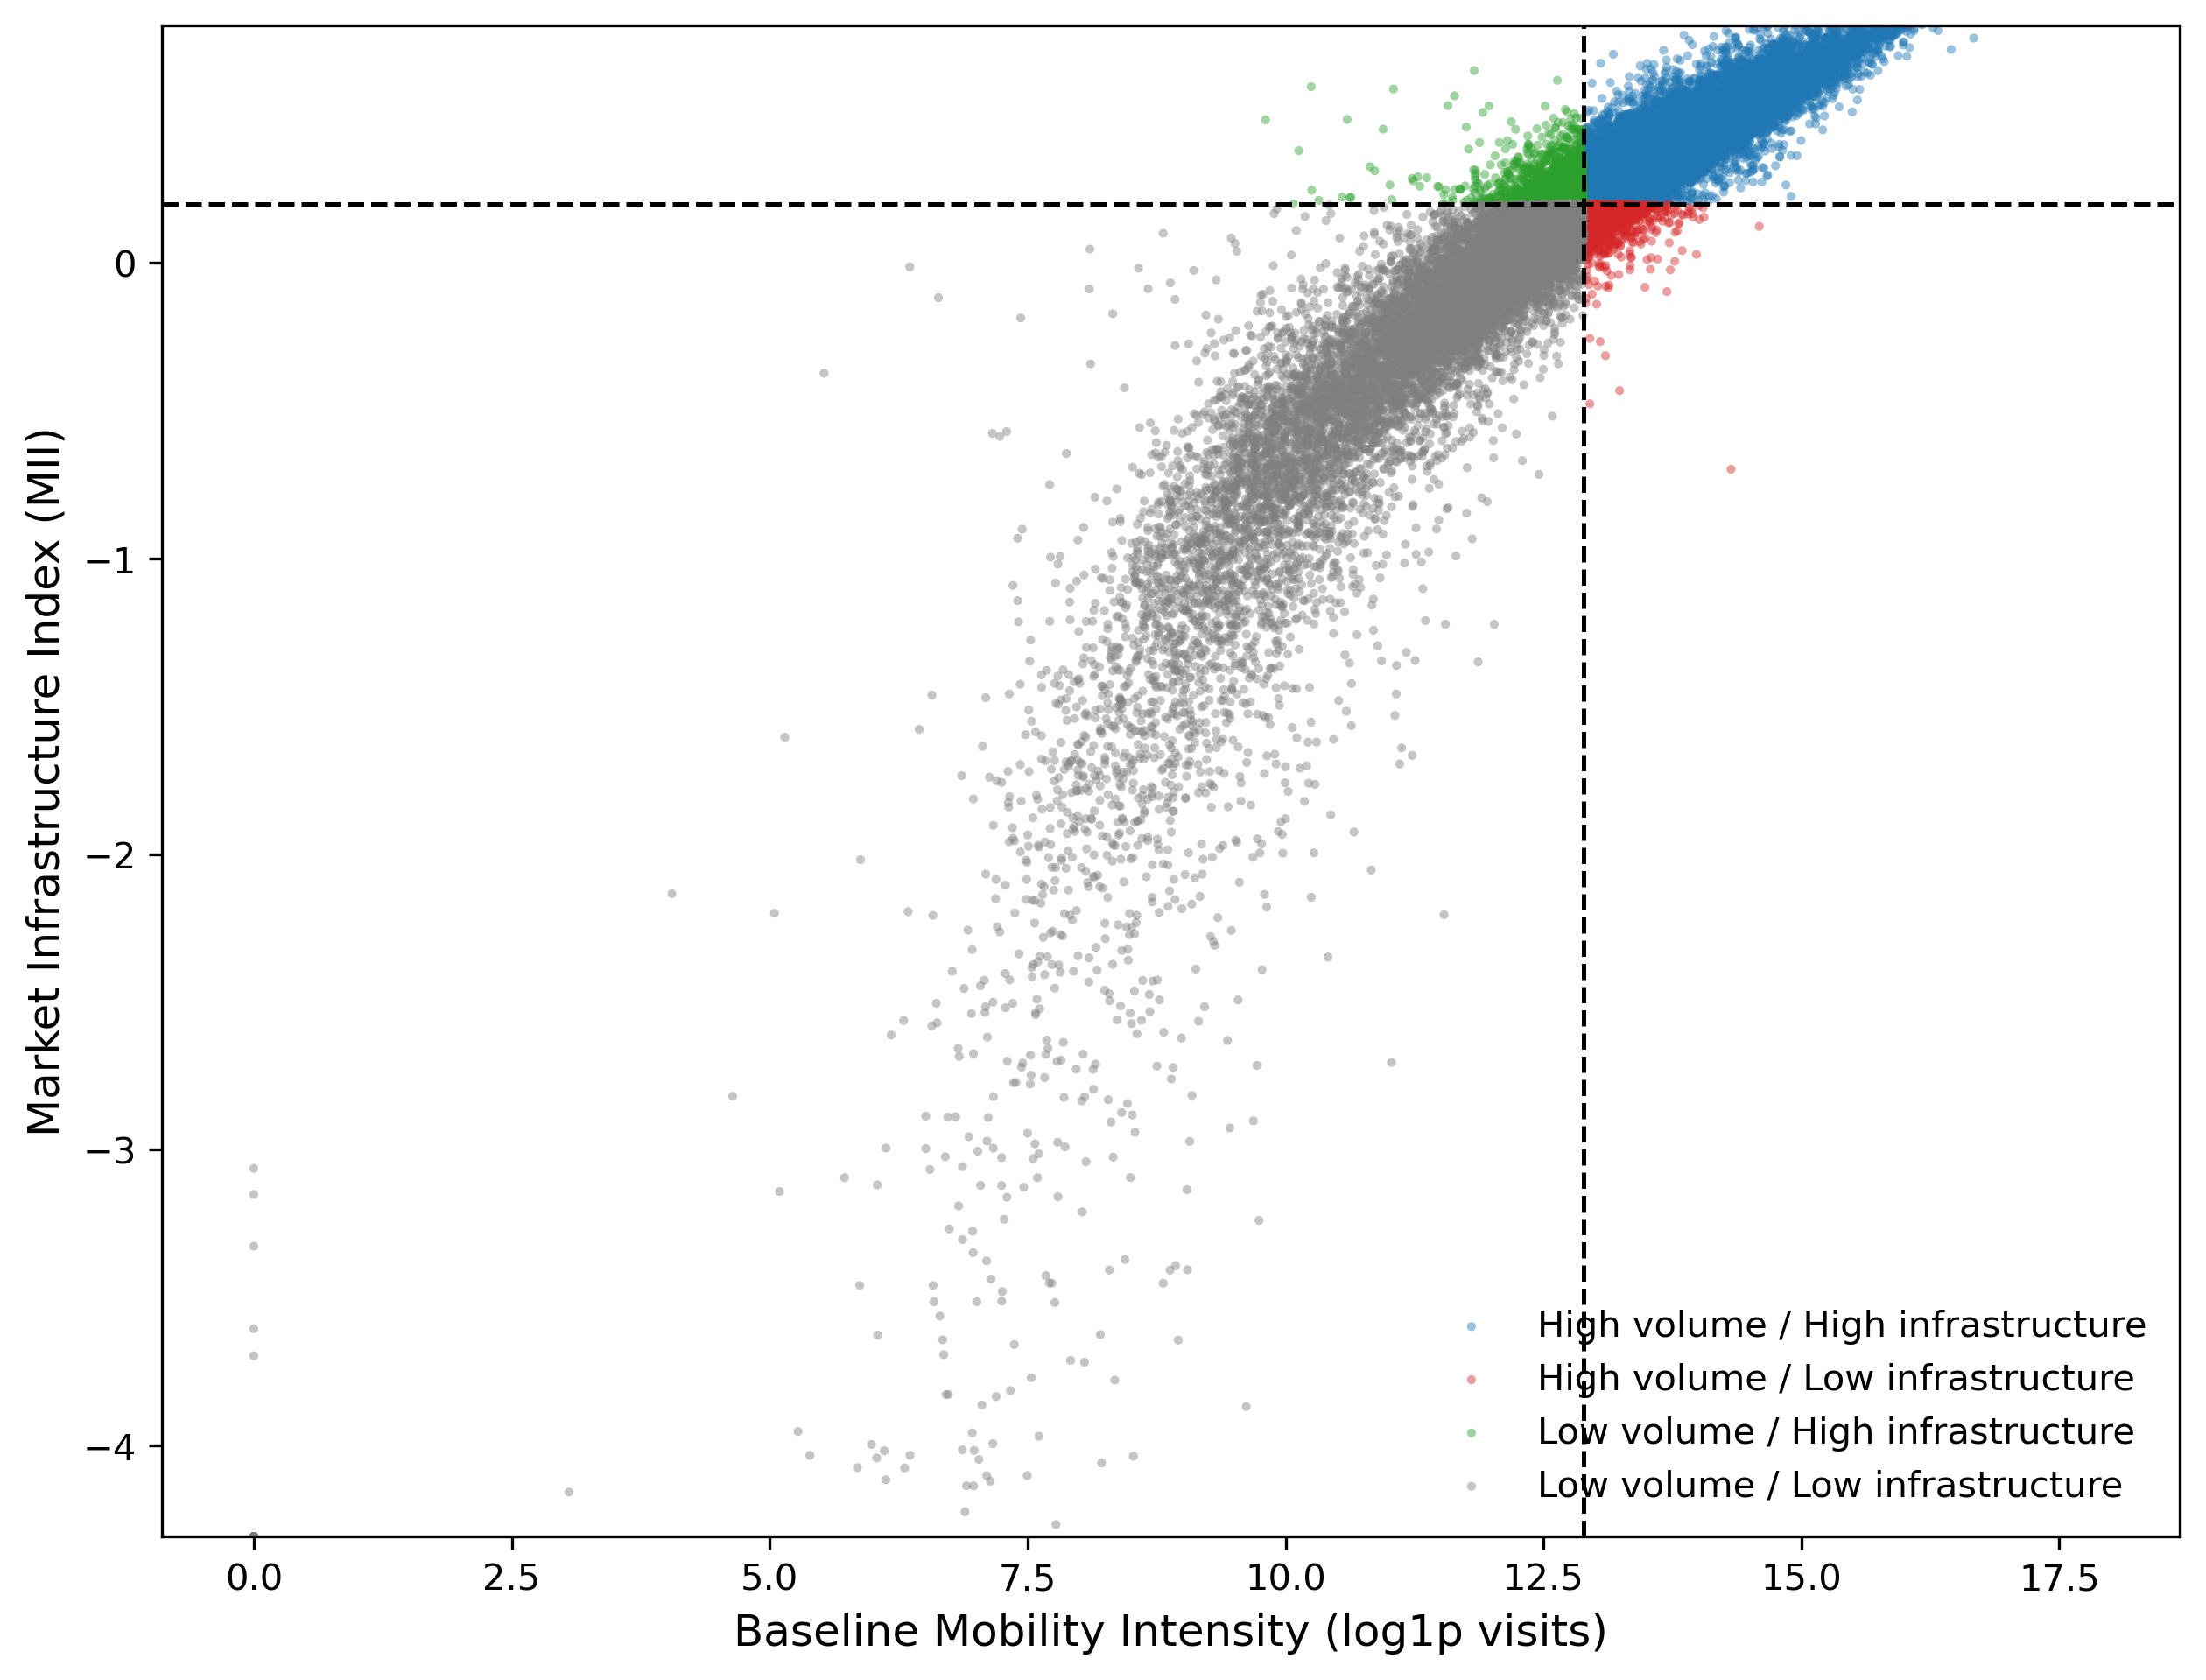

Figure 2 saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/Figure_2_MII_vs_Volume_Quadrants_JM.png


In [24]:
# ============================================================
# Figure 2 — Joint Distribution of Mobility Intensity and MII
# Publication-ready (Journal of Marketing style)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load data
# -----------------------------
DATA_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

df = pd.read_csv(DATA_PATH)

COL_X = "log1p_visits_A4"
COL_Y = "mii"

df = df[[COL_X, COL_Y]].dropna()

# -----------------------------
# 2. Compute medians (FULL DATA)
# -----------------------------
x_med = df[COL_X].median()
y_med = df[COL_Y].median()

# -----------------------------
# 3. Subsample for visualization ONLY
# -----------------------------
np.random.seed(42)
df_plot = df.sample(frac=0.07)  # 5–10% is ideal for JM figures

# -----------------------------
# 4. Assign quadrants
# -----------------------------
def quadrant(row):
    if row[COL_X] >= x_med and row[COL_Y] >= y_med:
        return "High volume / High infrastructure"
    elif row[COL_X] >= x_med and row[COL_Y] < y_med:
        return "High volume / Low infrastructure"
    elif row[COL_X] < x_med and row[COL_Y] >= y_med:
        return "Low volume / High infrastructure"
    else:
        return "Low volume / Low infrastructure"

df_plot["quadrant"] = df_plot.apply(quadrant, axis=1)

# -----------------------------
# 5. Axis limits (visual only)
# -----------------------------
y_low, y_high = df[COL_Y].quantile([0.01, 0.99])

# -----------------------------
# 6. Plot
# -----------------------------
plt.figure(figsize=(8.5, 6.5))

colors = {
    "High volume / High infrastructure": "#1f77b4",
    "High volume / Low infrastructure": "#d62728",
    "Low volume / High infrastructure": "#2ca02c",
    "Low volume / Low infrastructure": "#7f7f7f",
}

for q, c in colors.items():
    subset = df_plot[df_plot["quadrant"] == q]
    plt.scatter(
        subset[COL_X],
        subset[COL_Y],
        s=6,
        alpha=0.45,
        color=c,
        label=q,
        edgecolors="none",
    )

# Median lines
plt.axvline(x_med, linestyle="--", linewidth=1.2, color="black")
plt.axhline(y_med, linestyle="--", linewidth=1.2, color="black")

# Labels
plt.xlabel("Baseline Mobility Intensity (log1p visits)", fontsize=12)
plt.ylabel("Market Infrastructure Index (MII)", fontsize=12)

# Limits
plt.ylim(y_low, y_high)

# Legend
plt.legend(frameon=False, fontsize=10, loc="lower right")

# Clean style
plt.grid(False)
plt.tight_layout()

# -----------------------------
# 7. Save
# -----------------------------
OUTPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/"
    "Figure_2_MII_vs_Volume_Quadrants_JM.png"
)

plt.savefig(OUTPUT_PATH, dpi=300)
plt.show()

print("Figure 2 saved to:")
print(OUTPUT_PATH)

/var/folders/yj/wg7thtvj0l7_jlfnhgf4psgw0000gp/T/ipykernel_3220/4237539311.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


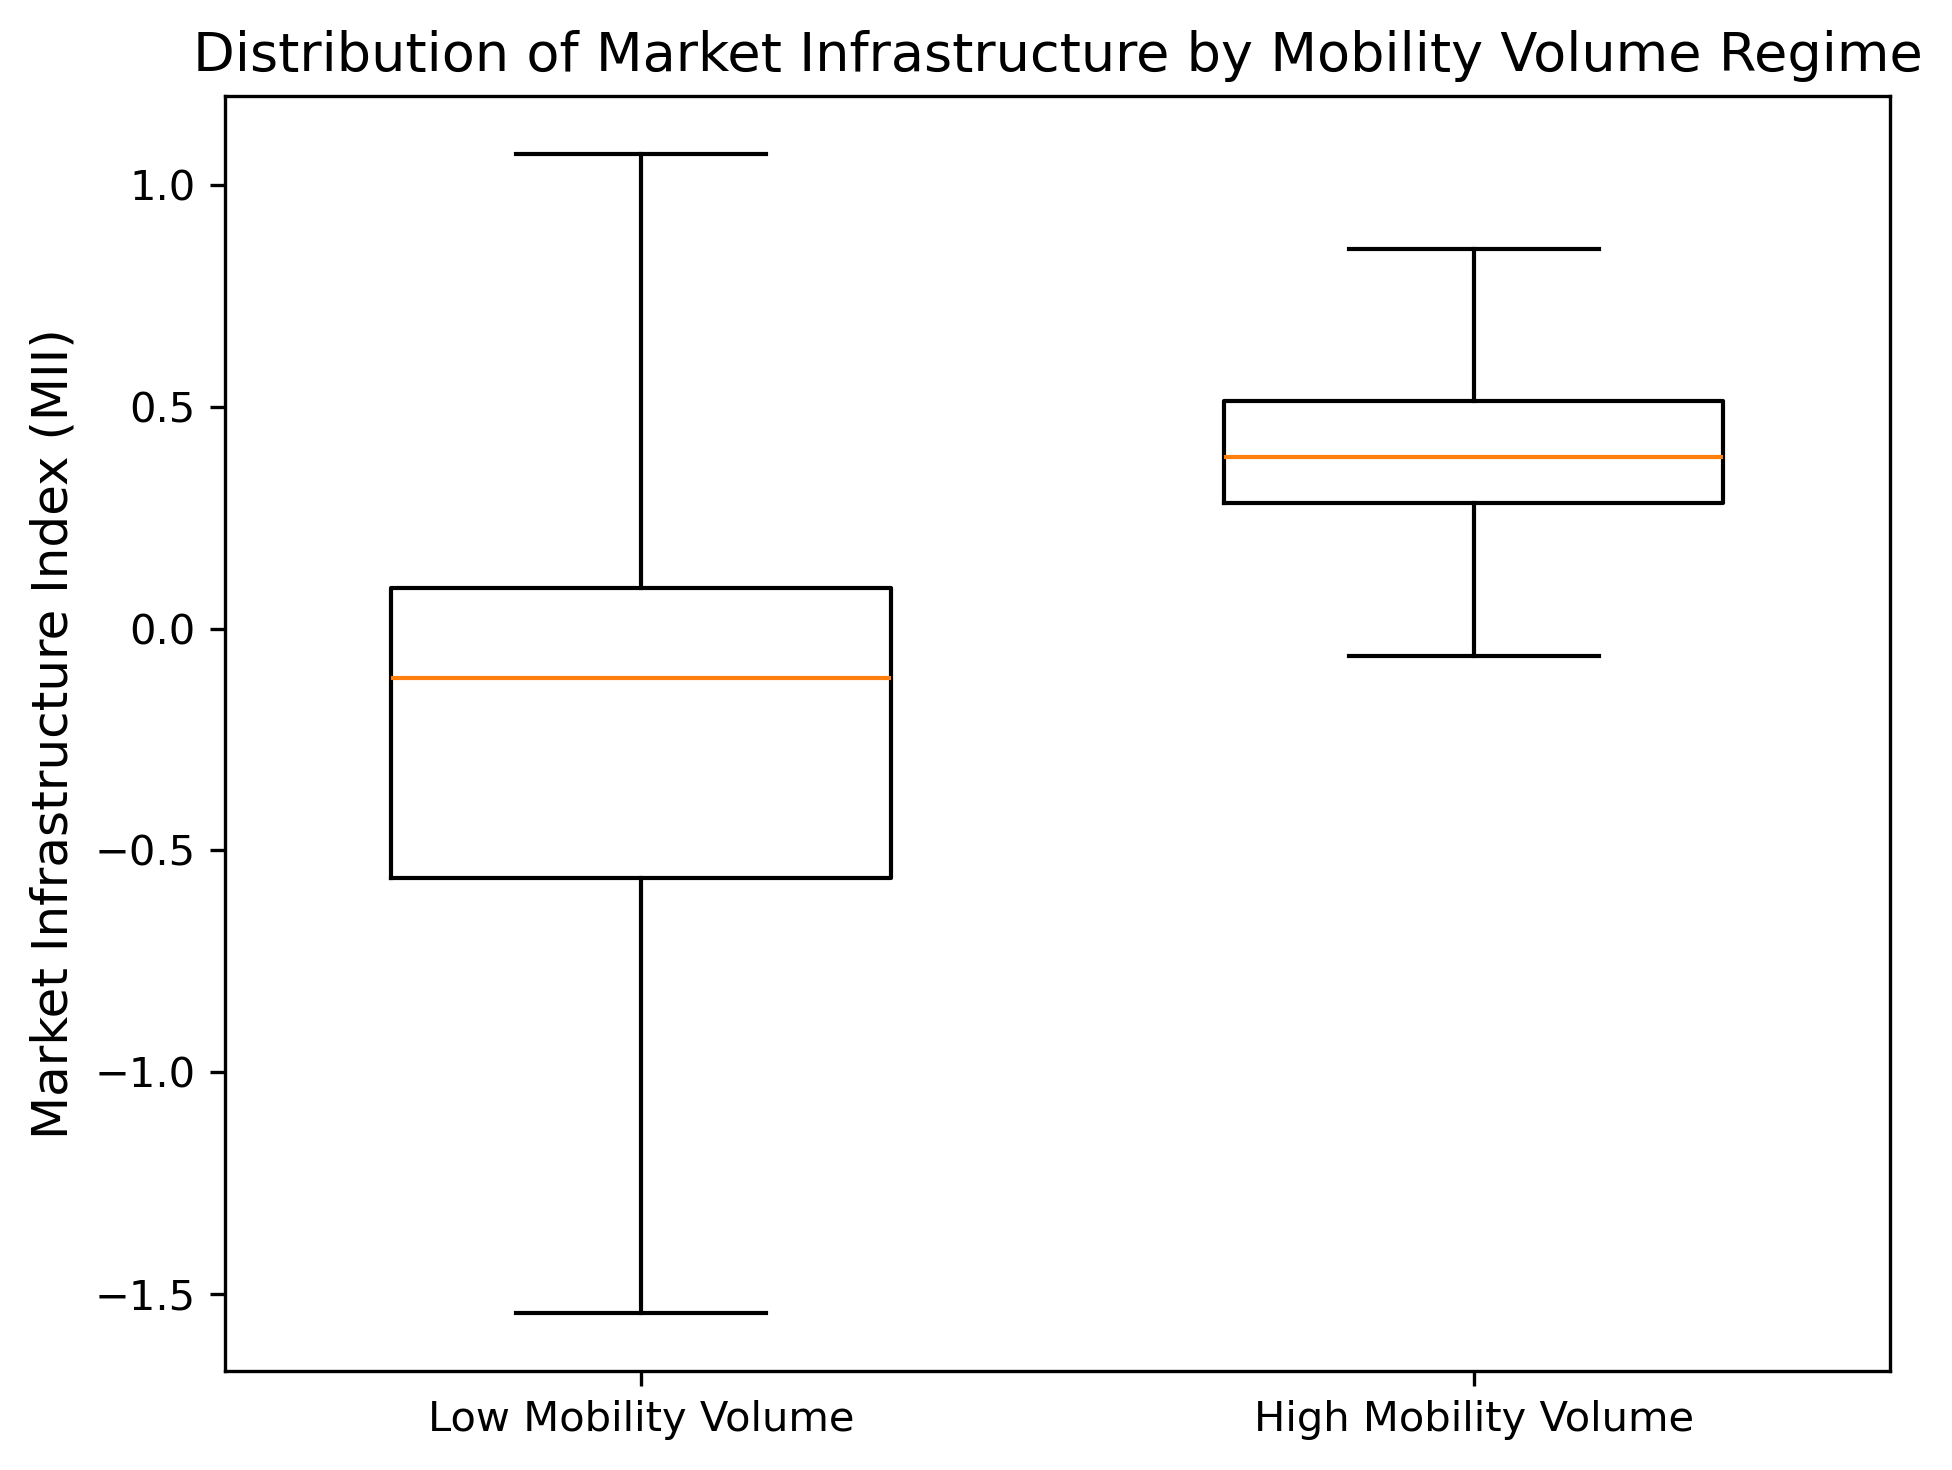

Figure 2 saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/Figure_2_MII_by_Volume_Regimes_BOXPLOT_JM.png


In [26]:
# ============================================================
# Figure 2 — MII Distribution by Volume Regimes (JM-Ready)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load data
# -----------------------------
DATA_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

df = pd.read_csv(DATA_PATH)

x = "log1p_visits_A4"
y = "mii"

df = df[[x, y]].dropna()

# -----------------------------
# Define volume regimes (quartiles or median)
# -----------------------------
volume_median = df[x].median()

df["volume_regime"] = np.where(
    df[x] >= volume_median,
    "High Mobility Volume",
    "Low Mobility Volume"
)

# -----------------------------
# Prepare data
# -----------------------------
low = df[df["volume_regime"] == "Low Mobility Volume"][y]
high = df[df["volume_regime"] == "High Mobility Volume"][y]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6.5, 5))

plt.boxplot(
    [low, high],
    labels=["Low Mobility Volume", "High Mobility Volume"],
    showfliers=False,
    widths=0.6
)

plt.ylabel("Market Infrastructure Index (MII)", fontsize=12)
plt.title("Distribution of Market Infrastructure by Mobility Volume Regime", fontsize=13)

plt.tight_layout()

# -----------------------------
# Save
# -----------------------------
OUTPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/"
    "Figure_2_MII_by_Volume_Regimes_BOXPLOT_JM.png"
)

plt.savefig(OUTPUT_PATH, dpi=300)
plt.show()

print("Figure 2 saved to:")
print(OUTPUT_PATH)

In [1]:
# ============================================================
# MII ABLATION ANALYSIS — STRUCTURAL NECESSITY
# ============================================================

import pandas as pd
from scipy.stats import spearmanr

# ------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------
INPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

df = pd.read_csv(INPUT_PATH)

# ------------------------------------------------------------
# 2. Define component groups
# ------------------------------------------------------------
VOLUME_COLS = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_new_visitors_A4"
]

RECURRENCE_COLS = [
    "z_log1p_repeat_visitors_A4"
]

STABILITY_COLS = [
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4"
]

DEPTH_COLS = [
    "z_dwell_time_mins"
]

FULL_COMPONENTS = (
    VOLUME_COLS
    + RECURRENCE_COLS
    + STABILITY_COLS
    + DEPTH_COLS
)

# ------------------------------------------------------------
# 3. Helper: recompute MII as simple mean of components
#    (consistent with your z-mean robustness checks)
# ------------------------------------------------------------
def compute_mii(df, cols):
    return df[cols].mean(axis=1)

# ------------------------------------------------------------
# 4. Compute ablated indices
# ------------------------------------------------------------
df["mii_full_recomputed"] = compute_mii(df, FULL_COMPONENTS)

df["mii_no_recurrence"] = compute_mii(
    df, VOLUME_COLS + STABILITY_COLS + DEPTH_COLS
)

df["mii_no_stability"] = compute_mii(
    df, VOLUME_COLS + RECURRENCE_COLS + DEPTH_COLS
)

df["mii_no_depth"] = compute_mii(
    df, VOLUME_COLS + RECURRENCE_COLS + STABILITY_COLS
)

# ------------------------------------------------------------
# 5. Compute Spearman correlations with full MII
# ------------------------------------------------------------
results = []

def spearman_with_full(colname):
    rho, _ = spearmanr(
        df["mii_full_recomputed"],
        df[colname],
        nan_policy="omit"
    )
    return rho

results.append({
    "specification": "Full MII (baseline)",
    "spearman_corr_with_full_mii": 1.0
})

for spec in ["mii_no_recurrence", "mii_no_stability", "mii_no_depth"]:
    results.append({
        "specification": spec,
        "spearman_corr_with_full_mii": spearman_with_full(spec)
    })

out = pd.DataFrame(results)
out["delta_vs_full"] = 1.0 - out["spearman_corr_with_full_mii"]

# ------------------------------------------------------------
# 6. Save final Table 2
# ------------------------------------------------------------
OUTPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/"
    "V2_ablation_correlations_FINAL.csv"
)

out.to_csv(OUTPUT_PATH, index=False)

print("✅ Table 2 (Ablation) saved to:")
print(OUTPUT_PATH)
print("\nPreview:")
display(out)

✅ Table 2 (Ablation) saved to:
/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V2_ablation_correlations_FINAL.csv

Preview:


,specification,spearman_corr_with_full_mii,delta_vs_full
0,Full MII (baseline),1.000000,0.000000
1,mii_no_recurrence,0.989409,0.010591
2,mii_no_stability,0.978948,0.021052
3,mii_no_depth,0.945341,0.054659


In [3]:
import pandas as pd

df = pd.read_csv(
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V3/V3_mii_rank_stability.csv"
)

df.head()

,perturbation,top10_overlap_with_mii
0,drop_visits,0.7602
1,drop_unique,0.8148
2,drop_dwell,0.7063
3,drop_repeat,0.7991
4,drop_new,0.8148


In [4]:
df.columns.tolist()

['perturbation', 'top10_overlap_with_mii']

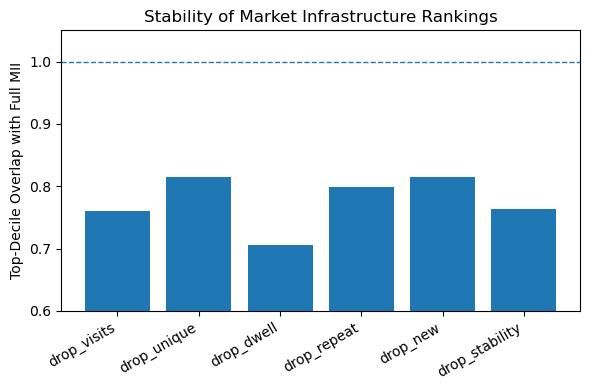

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Load rank stability results
# ------------------------------------------------------------
df = pd.read_csv(
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V3/V3_mii_rank_stability.csv"
)

# ------------------------------------------------------------
# Plot: Top-decile overlap under perturbation
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))

plt.bar(
    df["perturbation"],
    df["top10_overlap_with_mii"]
)

# Reference line for perfect stability
plt.axhline(
    y=1.0,
    linestyle="--",
    linewidth=1
)

plt.ylabel("Top-Decile Overlap with Full MII")
plt.ylim(0.6, 1.05)

plt.title("Stability of Market Infrastructure Rankings")

plt.xticks(rotation=30, ha="right")

plt.tight_layout()

plt.show()

In [9]:
import pandas as pd

df = pd.DataFrame({
    "perturbation": [
        "drop_visits",
        "drop_unique",
        "drop_dwell",
        "drop_repeat",
        "drop_new",
        "drop_stability"
    ],
    "top10_overlap_with_mii": [
        0.7602,
        0.8148,
        0.7063,
        0.7991,
        0.8148,
        0.7660
    ]
})

df

,perturbation,top10_overlap_with_mii
0,drop_visits,0.7602
1,drop_unique,0.8148
2,drop_dwell,0.7063
3,drop_repeat,0.7991
4,drop_new,0.8148
5,drop_stability,0.7660


In [10]:
output_csv = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/"
    "V3_rank_stability_FINAL.csv"
)

df.to_csv(output_csv, index=False)

print("Saved to:", output_csv)

Saved to: /Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V3_rank_stability_FINAL.csv


In [11]:
import matplotlib.pyplot as plt

label_map = {
    "drop_visits": "Remove visits",
    "drop_unique": "Remove unique visitors",
    "drop_dwell": "Remove dwell time (depth)",
    "drop_repeat": "Remove repeat visitors",
    "drop_new": "Remove new visitors",
    "drop_stability": "Remove stability"
}

df["label"] = df["perturbation"].map(label_map)
df = df.sort_values("top10_overlap_with_mii")

plt.figure(figsize=(8, 5))

plt.bar(
    df["label"],
    df["top10_overlap_with_mii"]
)

plt.ylim(0.65, 0.90)
plt.ylabel("Top-decile overlap with full MII", fontsize=11)
plt.xlabel("Component removed from MII", fontsize=11)

plt.title(
    "Stability of Market Infrastructure Rankings under Component Perturbation",
    fontsize=13,
    pad=10
)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()

output_fig = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/"
    "Figure_3_MII_rank_stability_JM.png"
)

plt.savefig(output_fig, dpi=300, bbox_inches="tight")
plt.close()

print("Figure 3 saved to:", output_fig)

Figure 3 saved to: /Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/Figure_3_MII_rank_stability_JM.png


In [13]:
print("=== Columns in merged dataframe ===")
for c in df.columns:
    print(c)

=== Columns in merged dataframe ===
ct_id
unique
visits
repeat_visitors
new_visitors
unique_q1
unique_q2
unique_q3
unique_q4
visits_q1
visits_q2
visits_q3
visits_q4
repeat_q1
repeat_q2
repeat_q3
repeat_q4
new_visitor_q1
new_visitor_q2
new_visitor_q3
new_visitor_q4
dwell_time_mins
unique_week_mean
unique_week_cv
visits_week_mean
visits_week_cv
unique_weeks_sum
unique_total_minus_weeks
visits_weeks_sum
visits_total_minus_weeks
log1p_visits_A4
log1p_unique_A4
log1p_repeat_visitors_A4
log1p_new_visitors_A4
stability_visits_week_cv_A4
stability_unique_week_cv_A4
z_dwell_time_mins
z_log1p_visits_A4
z_log1p_unique_A4
z_log1p_repeat_visitors_A4
z_log1p_new_visitors_A4
z_stability_visits_week_cv_A4
z_stability_unique_week_cv_A4
mii_zmean_A4
mii_pca1_A4
z_mii_zmean_A4
z_mii_pca1_A4
mii_x
mii_y
nl_mean
nl_median
nl_count
log_nl_mean


In [15]:
print(df.columns.tolist())

['ct_id', 'unique', 'visits', 'repeat_visitors', 'new_visitors', 'unique_q1', 'unique_q2', 'unique_q3', 'unique_q4', 'visits_q1', 'visits_q2', 'visits_q3', 'visits_q4', 'repeat_q1', 'repeat_q2', 'repeat_q3', 'repeat_q4', 'new_visitor_q1', 'new_visitor_q2', 'new_visitor_q3', 'new_visitor_q4', 'dwell_time_mins', 'unique_week_mean', 'unique_week_cv', 'visits_week_mean', 'visits_week_cv', 'unique_weeks_sum', 'unique_total_minus_weeks', 'visits_weeks_sum', 'visits_total_minus_weeks', 'log1p_visits_A4', 'log1p_unique_A4', 'log1p_repeat_visitors_A4', 'log1p_new_visitors_A4', 'stability_visits_week_cv_A4', 'stability_unique_week_cv_A4', 'z_dwell_time_mins', 'z_log1p_visits_A4', 'z_log1p_unique_A4', 'z_log1p_repeat_visitors_A4', 'z_log1p_new_visitors_A4', 'z_stability_visits_week_cv_A4', 'z_stability_unique_week_cv_A4', 'mii_zmean_A4', 'mii_pca1_A4', 'z_mii_zmean_A4', 'z_mii_pca1_A4', 'mii_x', 'mii_y', 'nl_mean', 'nl_median', 'nl_count', 'log_nl_mean']


In [17]:
print(df.columns.tolist())

['ct_id', 'mii', 'nl_mean', 'nl_median', 'nl_count', 'log_nl_mean']


In [18]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# ------------------------------------------------------------
# 1. Load dataset (MII + Nightlights)
# ------------------------------------------------------------

path = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

df = pd.read_csv(path)

# ------------------------------------------------------------
# 2. Column selection (CONFIRMED)
# ------------------------------------------------------------

COL_MII    = "mii"
COL_LIGHTS = "nl_mean"

df = df[[COL_MII, COL_LIGHTS]].dropna()

print(f"Number of census tracts used: {len(df):,}")

# ------------------------------------------------------------
# 3. Correlations
# ------------------------------------------------------------

pearson_r, pearson_p = pearsonr(df[COL_MII], df[COL_LIGHTS])
spearman_r, spearman_p = spearmanr(df[COL_MII], df[COL_LIGHTS])

# ------------------------------------------------------------
# 4. Bivariate regression
# ------------------------------------------------------------

model = sm.OLS(df[COL_LIGHTS], sm.add_constant(df[COL_MII])).fit()
r2 = model.rsquared

# ------------------------------------------------------------
# 5. Assemble Table 3
# ------------------------------------------------------------

table3 = pd.DataFrame({
    "Diagnostic": [
        "Pearson correlation (MII × Nighttime lights)",
        "Spearman rank correlation (MII × Nighttime lights)",
        "R² from bivariate regression (Nighttime lights ~ MII)"
    ],
    "Estimate": [
        pearson_r,
        spearman_r,
        r2
    ],
    "p_value": [
        pearson_p,
        spearman_p,
        np.nan
    ]
})

print("\n=== TABLE 3 — External Convergence with Nighttime Lights ===")
print(table3)

Number of census tracts used: 398,774

=== TABLE 3 — External Convergence with Nighttime Lights ===
                                          Diagnostic  Estimate  p_value
0       Pearson correlation (MII × Nighttime lights)  0.448432      0.0
1  Spearman rank correlation (MII × Nighttime lig...  0.672622      0.0
2  R² from bivariate regression (Nighttime lights...  0.201091      NaN


In [19]:
def format_p(p):
    if p < 0.001:
        return "< .001"
    else:
        return f"{p:.3f}"

table3["p_value_formatted"] = table3["p_value"].apply(
    lambda x: format_p(x) if pd.notnull(x) else "—"
)

table3_display = table3[["Diagnostic", "Estimate", "p_value_formatted"]]

print("\n=== TABLE 3 — External Convergence (Publication Format) ===")
print(table3_display)


=== TABLE 3 — External Convergence (Publication Format) ===
                                          Diagnostic  Estimate  \
0       Pearson correlation (MII × Nighttime lights)  0.448432   
1  Spearman rank correlation (MII × Nighttime lig...  0.672622   
2  R² from bivariate regression (Nighttime lights...  0.201091   

  p_value_formatted  
0            < .001  
1            < .001  
2                 —  


In [22]:
import pandas as pd
import glob

paths = glob.glob(
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline D (Downscaling)/"
    "D4_mii_grid_parts_csv/"
    "D4_mii_grid_part_*.csv.gz"
)

print("Example file:", paths[0])

df = pd.read_csv(paths[0], compression="gzip")
print(df.columns)
print(df.head())

Example file: /Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/D4_mii_grid_parts_csv/D4_mii_grid_part_0048.csv.gz
Index(['grid_id', 'ct_id', 'mii_grid', 'uf_code'], dtype='object')
    grid_id            ct_id  mii_grid  uf_code
0  94000000  261220810000008  0.000009       26
1  94000001  261220810000008  0.000009       26
2  94000002  261220810000008  0.000009       26
3  94000003  261220810000008  0.000009       26
4  94000004  261220810000008  0.000009       26
